# HW6: Train Neural Net for Digits Data Set

Blanca Miller <br />
STAT 760 <br />
03.22.2018 <br />

**Objective:** Learn to classify digits with a neural net. Using the digits dataset, reduce the dimensions of the dataset to 16 using PCA, then train a neural network for the 10 classes, and provide a confusion matrix to evaluate the performance of the classifying neural net. 

We'll use a multi-layer perceptron (MLP) to train the classifier model. MLP trains using gradient descent. The gradients are calculated using backpropogation. For classification, MLP minimizes the Cross-Entropy loss function.

**Digits Data Set:** https://web.stanford.edu/~hastie/ElemStatLearn/

#### Import Libraries

In [3]:
import sklearn
import itertools
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import decomposition
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

#### Function: Confusion Matrix

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Load Digits Data Set

In [5]:
train = pd.read_csv('digits_data.train', delimiter=' ', header=None)
test = pd.read_csv('digits_data.test', delimiter=' ', header=None)

In [6]:
# print data set dimensionality
print("Training set: {}".format(train.shape))
print("Testing set: {}".format(test.shape))

Training set: (7291, 258)
Testing set: (2007, 257)


In [7]:
# print subset (head) of training observations for verification
train.head()

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,257
0,6.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.631,0.862,...,0.823,1.000,0.482,-0.474,-0.991,-1.000,-1.000,-1.000,-1.0,NaN
1,5.0,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,...,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0,NaN
2,4.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-0.109,1.000,-0.179,-1.000,-1.000,-1.000,-1.0,NaN
3,7.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.273,0.684,0.960,0.450,...,1.000,0.536,-0.987,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,NaN
4,3.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.928,-0.204,0.751,0.466,...,0.639,1.000,1.000,0.791,0.439,-0.199,-0.883,-1.000,-1.0,NaN


In [8]:
# print subset (head) testing observations for verification
test.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,9,-1.0,-1.0,-1.0,-1.000,-1.0,-0.948,-0.561,0.148,0.384,...,-1.000,-0.908,0.430,0.622,-0.973,-1.000,-1.0,-1.0,-1.0,-1.0
1,6,-1.0,-1.0,-1.0,-1.000,-1.0,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
2,3,-1.0,-1.0,-1.0,-0.593,0.7,1.000,1.000,1.000,1.000,...,1.000,0.717,0.333,0.162,-0.393,-1.000,-1.0,-1.0,-1.0,-1.0
3,6,-1.0,-1.0,-1.0,-1.000,-1.0,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
4,6,-1.0,-1.0,-1.0,-1.000,-1.0,-1.000,-1.000,-0.858,-0.106,...,0.901,0.901,0.901,0.290,-0.369,-0.867,-1.0,-1.0,-1.0,-1.0


#### Convert Data Frame into Numpy Array

In [9]:
train_set = train.as_matrix()
test_set = test.as_matrix()

#### Parse Data Values from their Labels & Print Dimensions

In [10]:
# get all rows from 1st-(last-1) column
# last-1 is to remove NaN column that numpy inserted
X_train = train_set[:, 1:257]

# get all rows for 0th column
y_train = train_set[:, 0]

# get all rows for 1st - last columns
X_test = test_set[:, 1:]

# get all rows for 0th column
y_test = test_set[:, 0]

In [11]:
# print data & label set dimensionality for verification
print("Training Data: {}".format(X_train.shape))
print("Training Labels: {}".format(y_train.shape))
print("Testing Data: {}".format(X_test.shape))
print("Testing Labels: {}".format(y_test.shape))

Training Data: (7291, 256)
Training Labels: (7291,)
Testing Data: (2007, 256)
Testing Labels: (2007,)


#### Determine & Print Number of Samples & Features

In [12]:
n_trains = X_train.shape[0]
n_features = X_train.shape[1]

In [13]:
print("Number of Training Samples: {}".format(n_trains))
print("Number of Data Features: {}".format(n_features))

Number of Training Samples: 7291
Number of Data Features: 256


#### Standardize Data to Obtain Similar Inputs & Weight Magnitudes

In [14]:
# set axis to 1 to standardize by sample/vector, rather than by feature 
X_train = preprocessing.scale(X_train, axis=1)
X_test = preprocessing.scale(X_test, axis=1)

#### Principal Component Analysis

In [15]:
# designate number of principal components
k = 16

# construct object representing PCA operation, executed by "fit" method
pca = decomposition.PCA(n_components = k)

# execute PCA: identifies n components
pca.fit(X_train)

# project data: n dimensional reduced representation
X_train_trans = pca.transform(X_train)
X_test_trans = pca.transform(X_test)

# amount of information compressed in the chosen k components
pca.explained_variance_ratio_

array([0.15582707, 0.10293384, 0.06530886, 0.05641492, 0.04107802,
       0.03749884, 0.03463196, 0.02686704, 0.02640698, 0.02329143,
       0.02067199, 0.0186969 , 0.01606253, 0.01518529, 0.01486015,
       0.01334564])

In [27]:
X_train_trans.shape

(7291, 16)

In [16]:
# the percentage of cumulative variance - recommended to keep 70%+
pca.explained_variance_ratio_.sum()

0.669081469791873

**Analysis:** This value, the cumulative variance, tell us that reducing the data's dimensionality from the original 256 dimensions to the chosen 16 dimensions only removed ~30% of the information contained in the original components. This is OK because some of that information contains noise, such as in the form of outliers and redundancy. Thus, we are only retaining the components that provide the fundamental structure of the data set. 

In [17]:
components = pd.DataFrame(pca.components_)
components

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.020767,0.020892,0.020038,0.017383,0.011280,-0.001436,0.002770,0.074980,0.041810,-0.009762,...,-0.057267,0.023995,0.051138,-0.026917,-0.026235,-0.000480,0.013252,0.017844,0.019480,0.020427
1,0.003684,0.007541,0.013784,0.025167,0.041100,0.055579,0.051438,0.003358,0.023490,0.071997,...,-0.022188,-0.024049,-0.050959,-0.034106,-0.019799,-0.007247,0.001185,0.003255,0.003449,0.003018
2,-0.003664,0.000027,0.004500,0.011590,0.020164,0.024164,0.025705,0.046801,-0.004783,-0.046556,...,-0.030538,-0.020838,-0.035574,-0.061992,-0.021720,-0.001798,0.000242,-0.000865,-0.002337,-0.003997
3,0.000229,0.001276,-0.002920,-0.015478,-0.038011,-0.066440,-0.102984,-0.132646,-0.132645,-0.106963,...,-0.120585,-0.145045,-0.133225,-0.099457,-0.066500,-0.036361,-0.013576,-0.002375,0.001870,0.001240
4,-0.005367,0.000803,0.012565,0.035269,0.074511,0.107217,0.100940,0.006847,-0.041835,-0.053673,...,0.029224,-0.079775,-0.159146,-0.092637,-0.040494,-0.008839,0.012617,0.018684,0.010167,-0.001674
5,0.008705,0.020989,0.038342,0.057897,0.070894,0.058736,0.025441,0.029680,0.032366,0.020442,...,0.079886,0.058057,0.017508,-0.010492,-0.002588,0.002359,0.006143,0.006480,0.005991,0.005408
6,-0.000269,-0.001461,-0.000901,0.001844,0.007364,-0.003315,-0.051236,-0.100110,-0.095994,-0.051980,...,-0.055881,-0.109261,-0.016510,0.082550,0.078238,0.044593,0.018306,0.005159,0.001067,0.000370
7,0.003808,0.007155,0.008440,-0.001523,-0.036132,-0.101701,-0.172361,-0.205520,-0.091556,0.058496,...,-0.107305,-0.107256,-0.039567,0.055447,0.088753,0.074727,0.041190,0.019729,0.009248,0.003657
8,0.012085,0.015690,0.024078,0.035435,0.042810,0.036046,0.020979,0.028388,-0.015646,-0.024804,...,0.024562,0.000701,-0.036937,-0.044878,0.014082,0.029054,0.024137,0.019911,0.016647,0.013026
9,0.009734,0.007048,0.001281,-0.010769,-0.025673,-0.028260,-0.009452,0.040738,0.113036,0.143814,...,0.099123,0.134557,0.101309,0.057453,0.035107,0.018633,0.011715,0.012773,0.012190,0.010594


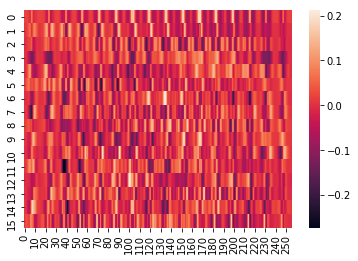

In [18]:
sb.heatmap(components)

## Train a 1 Hidden Layer Neural Net

In [19]:
# initialize classifier objects
clf_10 = MLPClassifier(hidden_layer_sizes=(10,))
clf_50 = MLPClassifier(hidden_layer_sizes=(50,))
clf_100 = MLPClassifier()
clf_150 = MLPClassifier(hidden_layer_sizes=(150,))
clf_199 = MLPClassifier(hidden_layer_sizes=(200,))

# fit the classifier model to the data matrix X and is targets y
clf_10.fit(X_train_trans, y_train)
clf_50.fit(X_train_trans, y_train)
clf_100.fit(X_train_trans, y_train)
clf_150.fit(X_train_trans, y_train)
clf_199.fit(X_train_trans, y_train)

/home/blanca/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [33]:
print("Training Data: {}".format(X_train_trans.shape))
print("Training Labels: {}".format(y_train.shape))

print("Testing Data: {}".format(X_test_trans.shape))
print("Testing Labels: {}".format(y_test.shape))

Training Data: (7291, 16)
Training Labels: (7291,)
Testing Data: (2007, 16)
Testing Labels: (2007,)


#### Determine Neural Nets Predictive Score

In [20]:
print("Training 10 hidden layer set score: %f" % clf_10.score(X_train_trans, y_train))
print("Test 10 hidden set score: %f" % clf_10.score(X_test_trans, y_test))

print("Training 50 hidden layer set score: %f" % clf_50.score(X_train_trans, y_train))
print("Test 50 hidden set score: %f" % clf_50.score(X_test_trans, y_test))

print("Training 100 hidden layer set score: %f" % clf_100.score(X_train_trans, y_train))
print("Test 100 hidden set score: %f" % clf_100.score(X_test_trans, y_test))

print("Training 150 hidden layer set score: %f" % clf_150.score(X_train_trans, y_train))
print("Test 150 hidden set score: %f" % clf_150.score(X_test_trans, y_test))

print("Training 199 hidden layer set score: %f" % clf_199.score(X_train_trans, y_train))
print("Test 199 hidden set score: %f" % clf_199.score(X_test_trans, y_test))

Training 10 hidden layer set score: 0.949527
Test 10 hidden set score: 0.899352
Training 50 hidden layer set score: 0.999451
Test 50 hidden set score: 0.930244
Training 100 hidden layer set score: 0.999863
Test 100 hidden set score: 0.938714
Training 150 hidden layer set score: 0.999863
Test 150 hidden set score: 0.938714
Training 199 hidden layer set score: 0.999863
Test 199 hidden set score: 0.941704


**Analysis:** The accuracy when using 1 hidden layer of 10 nodes was fairly accurate. As the number of the hidden nodes increased to 50, 100, and 150, there was a growth in accuracy. However, this growth slows and sometimes decreases as we approach the max number of nodes, 199.

Now that we've trained on the training set, we can predict labels for the test set.

#### Predict Labels for New Data

In [22]:
test_predictions_10 = clf_10.predict(X_test_trans)
test_predictions_50 = clf_50.predict(X_test_trans)
test_predictions_100 = clf_100.predict(X_test_trans)
test_predictions_150 = clf_150.predict(X_test_trans)
test_predictions_199 = clf_199.predict(X_test_trans)

In [30]:
X_train_trans.shape

(7291, 16)

In [31]:
test_predictions_10.shape

(2007,)

In [23]:
cm_10 = confusion_matrix(y_test, test_predictions_10)
cm_50 = confusion_matrix(y_test, test_predictions_50)
cm_100 = confusion_matrix(y_test, test_predictions_100)
cm_150 = confusion_matrix(y_test, test_predictions_150)
cm_199 = confusion_matrix(y_test, test_predictions_199)

In [32]:
cm_10.shape

(10, 10)

In [28]:
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Confusion matrix, without normalization
[[348   0   0   2   3   2   2   0   1   1]
 [  0 248   1   0   7   0   4   2   0   2]
 [  4   0 170   8   5   2   3   2   4   0]
 [  2   0   6 143   1  10   0   1   2   1]
 [  2   1   7   1 179   1   4   0   1   4]
 [  2   0   0  13   1 141   0   0   1   2]
 [  9   0   3   0   5   1 151   0   1   0]
 [  0   0   2   1   9   0   0 130   1   4]
 [  2   1   6   7   3   4   2   4 131   6]
 [  0   2   0   1   7   0   0   4   2 161]]


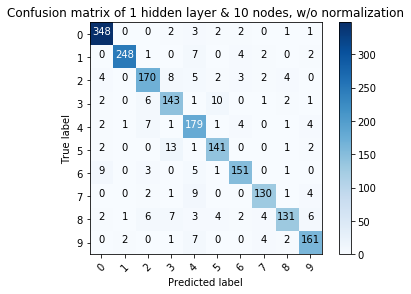

In [35]:
plot_confusion_matrix(cm_10, classes=class_names, title='Confusion matrix of 1 hidden layer & 10 nodes, w/o normalization')

Confusion matrix, without normalization
[[350   0   2   0   2   1   3   0   0   1]
 [  0 256   0   0   5   0   3   0   0   0]
 [  3   1 181   2   2   2   1   1   5   0]
 [  1   0   2 149   0  11   0   1   2   0]
 [  0   1   4   0 187   2   1   1   0   4]
 [  2   0   0   5   1 147   0   0   3   2]
 [  0   0   2   0   3   3 162   0   0   0]
 [  1   1   1   1   4   0   0 136   1   2]
 [  0   0   2   4   0   3   1   1 152   3]
 [  0   1   0   3   3   0   0   3   0 167]]


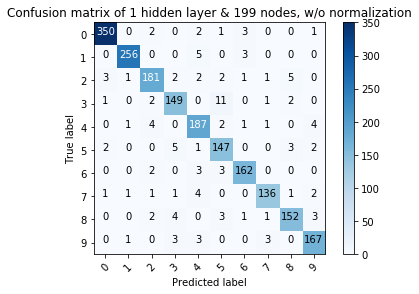

In [39]:
plot_confusion_matrix(cm_199, classes=class_names, title='Confusion matrix of 1 hidden layer & 199 nodes, w/o normalization')

## Train a 3 Hidden Layer Neural Net

In [40]:
# initialize classifier objects
clf_3_10 = MLPClassifier(hidden_layer_sizes=(10,3))
clf_3_50 = MLPClassifier(hidden_layer_sizes=(50,3))
clf_3_100 = MLPClassifier(hidden_layer_sizes=(100,3))
clf_3_150 = MLPClassifier(hidden_layer_sizes=(150,3))
clf_3_199 = MLPClassifier(hidden_layer_sizes=(200,3))

# fit the classifier model to the data matrix X and is targets y
clf_3_10.fit(X_train_trans, y_train)
clf_3_50.fit(X_train_trans, y_train)
clf_3_100.fit(X_train_trans, y_train)
clf_3_150.fit(X_train_trans, y_train)
clf_3_199.fit(X_train_trans, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [41]:
print("Training 3 hidden layer & 10 node set score: %f" % clf_3_10.score(X_train_trans, y_train))
print("Test 3 hidden layer & 10 node set score: %f" % clf_3_10.score(X_test_trans, y_test))

print("Training 3 hidden layer & 50 node set score: %f" % clf_3_50.score(X_train_trans, y_train))
print("Test 3 hidden layer & 50 node set score: %f" % clf_3_50.score(X_test_trans, y_test))

print("Training 3 hidden layer & 100 node layer set score: %f" % clf_3_100.score(X_train_trans, y_train))
print("Test 3 hidden layer & 100 node set score: %f" % clf_3_100.score(X_test_trans, y_test))

print("Training 3 hidden layer & 150 node layer set score: %f" % clf_3_150.score(X_train_trans, y_train))
print("Test 3 hidden layer & 150 node set score: %f" % clf_3_150.score(X_test_trans, y_test))

print("Training 3 hidden layer & 199 node layer set score: %f" % clf_3_199.score(X_train_trans, y_train))
print("Test 3 hidden layer & 199 node set score: %f" % clf_3_199.score(X_test_trans, y_test))

Training 3 hidden layer & 10 node set score: 0.905774
Test 3 hidden layer & 10 node set score: 0.858994
Training 3 hidden layer & 50 node set score: 0.970374
Test 3 hidden layer & 50 node set score: 0.892377
Training 3 hidden layer & 100 node layer set score: 0.985599
Test 3 hidden layer & 100 node set score: 0.895864
Training 3 hidden layer & 150 node layer set score: 0.995474
Test 3 hidden layer & 150 node set score: 0.904833
Training 3 hidden layer & 199 node layer set score: 0.997668
Test 3 hidden layer & 199 node set score: 0.914300


**Analysis:** Increasing the number of layers for the same number of nodes decresed the accuracy of prediction. A 3 hidden layers, 10 node model was several 3-4% less accurate than the 1 hidden layer, 10 node model and this pattern persisted as the number of nodes increased. Moreover, the 3 layer, 199 node model did not perform better than the 1 hidden layer, 50 node model.  

#### Predict Labels for New Data

In [42]:
test_predictions_3_10 = clf_3_10.predict(X_test_trans)
test_predictions_3_50 = clf_3_50.predict(X_test_trans)
test_predictions_3_100 = clf_3_100.predict(X_test_trans)
test_predictions_3_150 = clf_3_150.predict(X_test_trans)
test_predictions_3_199 = clf_3_199.predict(X_test_trans)

In [2]:
cm_3_10 = confusion_matrix(y_test, test_predictions_3_10)
cm_3_50 = confusion_matrix(y_test, test_predictions_3_50)
cm_3_100 = confusion_matrix(y_test, test_predictions_3_100)
cm_3_150 = confusion_matrix(y_test, test_predictions_3_150)
cm_3_199 = confusion_matrix(y_test, test_predictions_3_199)

NameError: name 'confusion_matrix' is not defined

Confusion matrix, without normalization
[[344   1   0   1   2   2   2   1   4   2]
 [  0 246   0   0   2   3   5   1   0   7]
 [  2   0 153   5   8   2   4   6  16   2]
 [  3   0   1 141   1  12   0   0   6   2]
 [  0   1   7   0 163   3   5   0   1  20]
 [  3   0   2  15   5 125   0   0   6   4]
 [  8   0   4   0   4   1 143   0   2   8]
 [  1   1   1   0   0   2   3 131   1   7]
 [  5   0   9   9   2   6   0   1 127   7]
 [  1   2   0   0  11   1   4   3   4 151]]


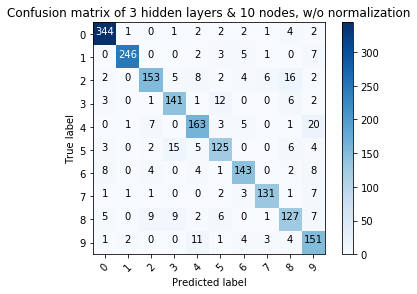

In [46]:
plot_confusion_matrix(cm_3_10, classes=class_names, title='Confusion matrix of 3 hidden layers & 10 nodes, w/o normalization')

Confusion matrix, without normalization
[[345   0   3   4   1   1   3   2   0   0]
 [  0 252   1   0   0   2   4   5   0   0]
 [  4   0 176   9   1   3   5   0   0   0]
 [  2   0   4 141   0  11   0   0   7   1]
 [  1   2   5   0 184   0   2   0   0   6]
 [  1   0   1   9   0 145   0   0   2   2]
 [  1   0   5   1   2   2 158   1   0   0]
 [  0   2   3   0   4   0   0 136   0   2]
 [  1   8   4   6   0  11   0   0 134   2]
 [  0   0   1   1   8   1   1   1   0 164]]


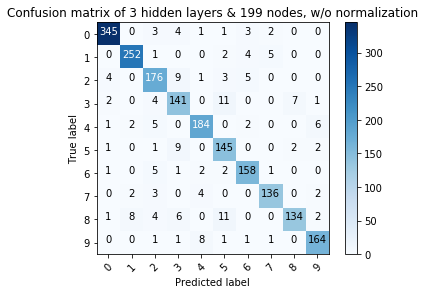

In [47]:
plot_confusion_matrix(cm_3_199, classes=class_names, title='Confusion matrix of 3 hidden layers & 199 nodes, w/o normalization')

## Train a 5 Hidden Layer Neural Net

In [48]:
# initialize classifier objects
clf_5_10 = MLPClassifier(hidden_layer_sizes=(10,5))
clf_5_50 = MLPClassifier(hidden_layer_sizes=(50,5))
clf_5_100 = MLPClassifier(hidden_layer_sizes=(100,5))
clf_5_150 = MLPClassifier(hidden_layer_sizes=(150,5))
clf_5_199 = MLPClassifier(hidden_layer_sizes=(200,5))

# fit the classifier model to the data matrix X and is targets y
clf_5_10.fit(X_train_trans, y_train)
clf_5_50.fit(X_train_trans, y_train)
clf_5_100.fit(X_train_trans, y_train)
clf_5_150.fit(X_train_trans, y_train)
clf_5_199.fit(X_train_trans, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [49]:
print("Training 5 hidden layer & 10 node set score: %f" % clf_5_10.score(X_train_trans, y_train))
print("Test 5 hidden layer & 10 node set score: %f" % clf_5_10.score(X_test_trans, y_test))

print("Training 5 hidden layer & 50 node set score: %f" % clf_5_50.score(X_train_trans, y_train))
print("Test 5 hidden layer & 50 node set score: %f" % clf_5_50.score(X_test_trans, y_test))

print("Training 5 hidden layer & 100 node layer set score: %f" % clf_5_100.score(X_train_trans, y_train))
print("Test 5 hidden layer & 100 node set score: %f" % clf_5_100.score(X_test_trans, y_test))

print("Training 5 hidden layer & 150 node layer set score: %f" % clf_5_150.score(X_train_trans, y_train))
print("Test 5 hidden layer & 150 node set score: %f" % clf_5_150.score(X_test_trans, y_test))

print("Training 5 hidden layer & 199 node layer set score: %f" % clf_5_199.score(X_train_trans, y_train))
print("Test 5 hidden layer & 199 node set score: %f" % clf_5_199.score(X_test_trans, y_test))

Training 5 hidden layer & 10 node set score: 0.937320
Test 5 hidden layer & 10 node set score: 0.889387
Training 5 hidden layer & 50 node set score: 0.994788
Test 5 hidden layer & 50 node set score: 0.915296
Training 5 hidden layer & 100 node layer set score: 0.998628
Test 5 hidden layer & 100 node set score: 0.920777
Training 5 hidden layer & 150 node layer set score: 0.999314
Test  hidden layer & 150 node set score: 0.920777
Training 5 hidden layer & 199 node layer set score: 0.998766
Test 5 hidden layer & 199 node set score: 0.913802


**Analysis:** The 5 hidden layer models perform slightly better thatn the 3 layer models, however, overall they are not performing better than the 1 layer implementation.

#### Predict Labels for New Data

In [51]:
test_predictions_5_10 = clf_5_10.predict(X_test_trans)
test_predictions_5_50 = clf_5_50.predict(X_test_trans)
test_predictions_5_100 = clf_5_100.predict(X_test_trans)
test_predictions_5_150 = clf_5_150.predict(X_test_trans)
test_predictions_5_199 = clf_5_199.predict(X_test_trans)

In [52]:
cm_5_10 = confusion_matrix(y_test, test_predictions_5_10)
cm_5_50 = confusion_matrix(y_test, test_predictions_5_50)
cm_5_100 = confusion_matrix(y_test, test_predictions_5_100)
cm_5_150 = confusion_matrix(y_test, test_predictions_5_150)
cm_5_199 = confusion_matrix(y_test, test_predictions_5_199)

Confusion matrix, without normalization
[[341   0   0   2   2   3   3   0   7   1]
 [  0 247   2   0   1   1   4   5   2   2]
 [  6   1 167   3   5   4   2   0  10   0]
 [  1   0   3 141   0  15   0   2   4   0]
 [  0   1   5   0 178   5   3   1   1   6]
 [  6   0   2   8   2 136   2   0   3   1]
 [  3   0   5   0   4   2 153   0   2   1]
 [  2   0   1   2   4   0   0 133   1   4]
 [  1   0  10   6   4   2   2   2 130   9]
 [  0   0   0   1   3   0   0  11   3 159]]


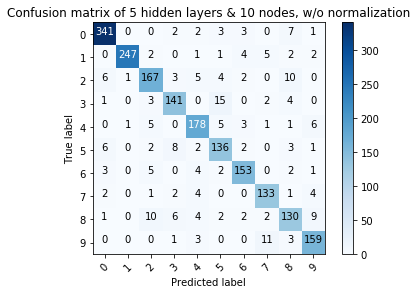

In [53]:
plot_confusion_matrix(cm_5_10, classes=class_names, title='Confusion matrix of 5 hidden layers & 10 nodes, w/o normalization')

Confusion matrix, without normalization
[[347   0   1   0   3   2   2   1   2   1]
 [  1 252   1   2   2   1   2   0   2   1]
 [  4   0 175   5   2   1   0   1   7   3]
 [  1   1   3 146   2  10   0   2   1   0]
 [  2   1   6   0 176   2   2   0   5   6]
 [  3   2   0   6   1 145   0   0   2   1]
 [  3   0   2   0   2   1 158   0   4   0]
 [  0   2   1   3   3   0   0 133   1   4]
 [  1   0   3   4   3   4   4   2 141   4]
 [  0   2   0   5   2   0   0   2   5 161]]


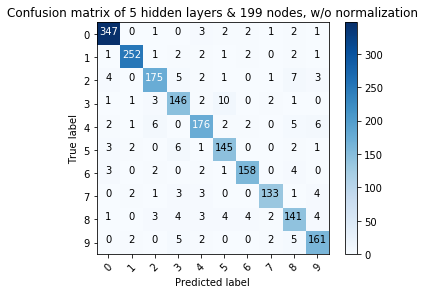

In [54]:
plot_confusion_matrix(cm_5_199, classes=class_names, title='Confusion matrix of 5 hidden layers & 199 nodes, w/o normalization')

## Train a 10 Hidden Layer Neural Net

In [55]:
# initialize classifier objects
clf_10_10 = MLPClassifier(hidden_layer_sizes=(10,10))
clf_10_50 = MLPClassifier(hidden_layer_sizes=(50,10))
clf_10_100 = MLPClassifier(hidden_layer_sizes=(100,10))
clf_10_150 = MLPClassifier(hidden_layer_sizes=(150,10))
clf_10_199 = MLPClassifier(hidden_layer_sizes=(200,10))

# fit the classifier model to the data matrix X and is targets y
clf_10_10.fit(X_train_trans, y_train)
clf_10_50.fit(X_train_trans, y_train)
clf_10_100.fit(X_train_trans, y_train)
clf_10_150.fit(X_train_trans, y_train)
clf_10_199.fit(X_train_trans, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [56]:
print("Training 10 hidden layer & 10 node set score: %f" % clf_10_10.score(X_train_trans, y_train))
print("Test 10 hidden layer & 10 node set score: %f" % clf_10_10.score(X_test_trans, y_test))

print("Training 10 hidden layer & 50 node set score: %f" % clf_10_50.score(X_train_trans, y_train))
print("Test 10 hidden layer & 50 node set score: %f" % clf_10_50.score(X_test_trans, y_test))

print("Training 10 hidden layer & 100 node layer set score: %f" % clf_10_100.score(X_train_trans, y_train))
print("Test 10 hidden layer & 100 node set score: %f" % clf_10_100.score(X_test_trans, y_test))

print("Training 10 hidden layer & 150 node layer set score: %f" % clf_10_150.score(X_train_trans, y_train))
print("Test 10 hidden layer & 150 node set score: %f" % clf_10_150.score(X_test_trans, y_test))

print("Training 10 hidden layer & 199 node layer set score: %f" % clf_10_199.score(X_train_trans, y_train))
print("Test 10 hidden layer & 199 node set score: %f" % clf_10_199.score(X_test_trans, y_test))

Training 5 hidden layer & 10 node set score: 0.953367
Test 5 hidden layer & 10 node set score: 0.896861
Training 5 hidden layer & 50 node set score: 0.999863
Test 5 hidden layer & 50 node set score: 0.925760
Training 5 hidden layer & 100 node layer set score: 0.999863
Test 5 hidden layer & 100 node set score: 0.936721
Training 5 hidden layer & 150 node layer set score: 0.999863
Test  hidden layer & 150 node set score: 0.932735
Training 5 hidden layer & 199 node layer set score: 0.999863
Test 5 hidden layer & 199 node set score: 0.934230


**Analysis:** Using 10 hidden layers has gotten more comparable results to the 1 layer model across the different node dimensions.

#### Predict Labels for New Data

In [57]:
test_predictions_10_10 = clf_10_10.predict(X_test_trans)
test_predictions_10_50 = clf_10_50.predict(X_test_trans)
test_predictions_10_100 = clf_10_100.predict(X_test_trans)
test_predictions_10_150 = clf_10_150.predict(X_test_trans)
test_predictions_10_199 = clf_10_199.predict(X_test_trans)

In [58]:
cm_10_10 = confusion_matrix(y_test, test_predictions_10_10)
cm_10_50 = confusion_matrix(y_test, test_predictions_10_50)
cm_10_100 = confusion_matrix(y_test, test_predictions_10_100)
cm_10_150 = confusion_matrix(y_test, test_predictions_10_150)
cm_10_199 = confusion_matrix(y_test, test_predictions_10_199)

Confusion matrix, without normalization
[[346   0   0   2   2   4   4   0   0   1]
 [  0 249   3   1   1   1   3   2   1   3]
 [  3   0 172   5   9   2   2   2   3   0]
 [  2   0   4 143   0  12   0   1   3   1]
 [  0   2   9   1 176   2   2   1   2   5]
 [  6   0   0  11   1 135   0   1   5   1]
 [  6   0   3   0   4   4 152   0   1   0]
 [  0   0   1   2   4   2   0 129   2   7]
 [  1   0   2   6   3   9   0   3 136   6]
 [  0   0   0   1   7   0   0   5   2 162]]


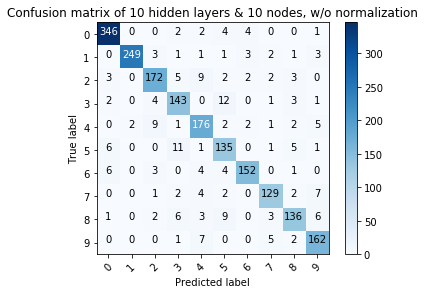

In [59]:
plot_confusion_matrix(cm_10_10, classes=class_names, title='Confusion matrix of 10 hidden layers & 10 nodes, w/o normalization')

Confusion matrix, without normalization
[[348   0   2   0   2   3   3   0   0   1]
 [  0 252   0   0   6   0   4   1   1   0]
 [  4   0 179   1   3   2   1   1   7   0]
 [  2   0   1 150   0   9   0   1   3   0]
 [  0   1   3   0 186   2   2   0   1   5]
 [  1   0   0   6   1 148   0   0   2   2]
 [  1   0   3   0   3   1 162   0   0   0]
 [  0   1   1   1   4   1   0 135   1   3]
 [  0   0   2   3   1   3   1   1 149   6]
 [  0   2   0   2   5   0   0   1   1 166]]


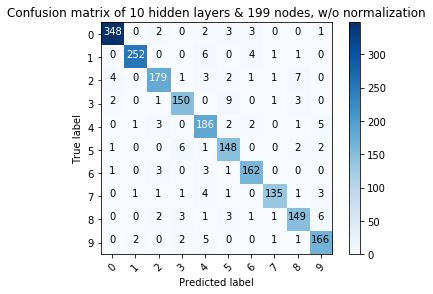

In [60]:
plot_confusion_matrix(cm_10_199, classes=class_names, title='Confusion matrix of 10 hidden layers & 199 nodes, w/o normalization')